In [211]:
import os
import nltk
import sys
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
from pyspark.mllib.clustering import LDA, LDAModel
import threading
from pyspark.ml.clustering import LDA
from pyspark.sql.types import *
from pyspark.sql import *
import re 
import struct
#import pyLDAvis
from struct import *
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StringType, ArrayType
import pandas as pd
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer, HashingTF, IDF
from array import array
from pyspark.ml.feature import Word2Vec
from openpyxl import Workbook
from pyspark.sql.types import ArrayType, StringType
from time import time
import gensim
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xlsxwriter
warnings.filterwarnings("ignore")

In [212]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import os
import codecs

lemma = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to C:\Users\VA Lab
[nltk_data]     11\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\VA Lab
[nltk_data]     11\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [213]:
spark = SparkSession.builder \
         .appName("spark-nltk") \
         .getOrCreate()

data = spark.read.csv("gnm_comments.csv", header=True) #gives a dataframe
sc = spark.sparkContext

In [214]:
comment_text = data.select('comment_text')
comment_text=comment_text.replace(r'\\n\\n|\\n',' ')
comment_text=comment_text.replace(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""",' ')

In [215]:
def cleanup_text(text):
    
    exclude = set(string.punctuation)
    translate_table = dict((ord(char), None) for char in string.punctuation)
    no_punct = text.lower().translate(translate_table)
    words = no_punct.split()
    #words = translate_table
    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any', u'are', u'arent', u'as', u'at', 
    u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by', 
    u'can', 'cant', 'come', u'could', 'couldnt', 
    u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during', 
    u'each', 
    u'few', 'finally', u'for', u'from', u'further', 
    u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here', u'hers', u'herself', u'him', u'himself', u'his', u'how', 
    u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself', 
    u'just', 
    u'll', 
    u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself', 
    u'no', u'nor', u'not', u'now', 
    u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves', u'out', u'over', u'own', 
    u'r', u're', 
    u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such', 
    u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then', u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too', 
    u'under', u'until', u'up', 
    u'very', 
    u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while', u'who', u'whom', u'why', u'will', u'with', u'wont', u'would', 
    u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']
    
    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['per', u'one', u'tell', u'need', u'say', u'new', u'try', u'take', u'may', u'come', u'get', 
    u'two', u'three', u'get', u'would', u'seem', u'want', u'hey', u'might', u'may', u'withot', u'with', u'also', 
    u'make', u'want', u'put', u'etc', u'actually', u'else', u'far', u'definitely', u'youll', u'didnt', u'isnt', 
    u'theres', u'since', u'able', u'maybe', u'sort', u'think', u'know', u'look', u'please', u'one', u'null', u'dont',
    u'could', u'unable', u'someday', u'best', u'better', u'someone', u'sure', u'lot', u'thank', u'also', u'anyone', u'really',
    u'something', u'give', u'years', u'use', u'all', u'ago', u'many', u'right', u'call', u'include', u'part', u'find',
    u'become', u'choose', u'chosen', u'as', u'back', u'good', u'right', u'see', u'good', u'even',u'first', u'low', u'less', u'much', u'another', u'mine',
    u'instead', u'will', u'never', u'ask', u'even', u'see', u'allow', u'still', u'that', u'you',
    u'disagree', u'obviously', u'self', u'bye', u'well', u'make', u'take', u'let',
    u'get', u'agree', u'leave', u'live', u'say', u'tell', u'understand', u'look', u'with', u'without',u'seem', u'bad',
    u'nothing', u'everything', u'give', u'long', u'think', u'show', u'last', u'run', u'day', u'great', 
    u'try', u'yes', u'no', u'live', u'right', u'perhaps', u'already', u'never', u'ever', u'just',   
    u'rather', u'however', u'real', u'least', u'good', u'bring', u'other', u'another', u'away', u'youre',     
    u'enough', u'want', u'mine', u'yours', u'hear', u'either', u'nor', u'neither', u'look', u'however',
    u'know', u'come', u'without', u'most', u'least', u'less', u'few', u'nah', u'bye', u'told'
    u'often', u'nah', u'bye', u'little', u'high', u'anything', u'wrong', u'though', u'always', u'every', 
    u'around', u'yet', u'little', u'like']
    
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]    
    
    normalized = [lemma.lemmatize(word,'v') for word in words]
    text_out = [re.sub('[^a-zA-Z0-9]','',word) for word in normalized]                                       # Remove special characters
    text_out = [word.lower() for word in text_out if len(word)>2 and word.lower() not in stopwords]     # Remove stopwords and words under X length
    
    #normalized = " ".join(lemma.lemmatize(word,'v') for word in words)
    text_out = " ".join(lemma.lemmatize(word,'v') for word in text_out)
 
    #x = normalized.split()
    #y = [s for s in x if len(s) > 2]
    
    return text_out

In [247]:
#def cleanup_text2(text):
#    return "j"

In [248]:
udf_cleantext = udf(cleanup_text, StringType())
#print(data.comment_text)
#comment_text.select("comment_text").show()

In [249]:
#cleanup_text('i see seem you dog')

In [250]:
clean_text = data.withColumn("clean_comm", udf_cleantext(data.comment_text))
clean_text.select("clean_comm").show(3)

+--------------------+
|          clean_comm|
+--------------------+
|program work prob...|
|offshoring revers...|
|spell exploitatio...|
+--------------------+
only showing top 3 rows



In [251]:
tokenizer = Tokenizer(inputCol="clean_comm", outputCol="tokens")

In [252]:
tokenized = tokenizer.transform(clean_text)
e = tokenized.select("clean_comm", "tokens")
tokenized.select("clean_comm", "tokens").show(1)

+--------------------+--------------------+
|          clean_comm|              tokens|
+--------------------+--------------------+
|program work prob...|[program, work, p...|
+--------------------+--------------------+
only showing top 1 row



In [253]:
remover = StopWordsRemover(inputCol="tokens", outputCol="tokens_Stop")

In [254]:
t = remover.transform(e)
tt = t.select('tokens_Stop')
tt.show(2)

+--------------------+
|         tokens_Stop|
+--------------------+
|[program, work, p...|
|[offshoring, reve...|
+--------------------+
only showing top 2 rows



In [255]:
tt = tt.select('tokens_Stop')
tt = tt.limit(100) #you can choose number or comments you want to run LDA on

In [256]:
#tt.toPandas().to_csv('cleaning.csv')  #-Uncomment if oyu want to save a cleaned model

In [257]:
#Term Frequency Vectorization  - Option 1 (HashingTF)
#cv = HashingTF(inputCol="tokens_Stop", outputCol="Rawfeatures")
#featurizedData = cv.transform(tt)
#featurizedData.show(1)

In [258]:
# Term Frequency Vectorization  - Option 2 (CountVectorizer):
start = time()
cv = CountVectorizer(inputCol="tokens_Stop", outputCol="Rawfeatures")
cvmodel = cv.fit(tt)
featurizedData = cvmodel.transform(tt)
 
vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)
print ('used CV: {:.2f}s'.format(time()-start))

used CV: 10.42s


In [259]:
start = time()
idf = IDF(inputCol="Rawfeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData) # TFIDF
print ('used IDF: {:.2f}s'.format(time()-start))

used IDF: 8.93s


In [260]:
rescaledData.count()

100

In [261]:
p = rescaledData.select('features')
p = p.limit(100) # you can choose number or comments you want to run LDA on
p.count()
#p.show(3)

100

In [262]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

In [263]:
start = time()
lda = LDA(k=3, maxIter=500)
model = lda.fit(p)
print ('used LDA: {:.2f}s'.format(time()-start))

used LDA: 53.82s


In [264]:
model.isDistributed()

False

In [266]:
#start = time()
#ll = model.logLikelihood(p)
#lp = model.logPerplexity(p)
#print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
#print("The upper bound on perplexity: " + str(lp))
#print ('used: {:.2f}s'.format(time()-start))

start = time()
# Describe topics.
topics = model.describeTopics(15)
print("The topics described by their top-weighted terms:")
topics.show(10)
print ('used to Describe: {:.2f}s'.format(time()-start))

start = time()
# Shows the result
transformed = model.transform(p)
transformed = transformed.select("topicDistribution")
transformed.show(10, truncate = False)
print ('used to Transform: {:.2f}s'.format(time()-start))

The topics described by their top-weighted terms:
+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[34, 4, 16, 0, 14...|[0.01287190509133...|
|    1|[62, 19, 154, 128...|[0.01319497678085...|
|    2|[2, 31, 6, 3, 1, ...|[0.01015233606848...|
+-----+--------------------+--------------------+

used to Describe: 0.11s
+----------------------------------------------------------------+
|topicDistribution                                               |
+----------------------------------------------------------------+
|[2.0981264251791296E-4,2.0085659051352544E-4,0.9995893307669687]|
|[3.7776624091903546E-4,0.9991202758699171,5.019578891636744E-4] |
|[0.9986261792988835,5.753016157070577E-4,7.98519085409337E-4]   |
|[2.619483679556125E-4,2.507668529729078E-4,0.9994872847790714]  |
|[2.617934363704871E-4,2.506185347897054E-4,0.9994875880288397]  |
|[2.2215674570558232E-4,0.7636671196411

In [235]:
def indices_to_terms(vocabulary):
    def indices_to_terms(xs):
        return [vocabulary[int(x)] for x in xs]
    return udf(indices_to_terms, ArrayType(StringType()))

In [236]:
hh = topics.withColumn("topics_words", indices_to_terms(cvmodel.vocabulary)("termIndices"))
hh = hh.select("topic", "termWeights", "topics_words")
hh.show(10)

+-----+--------------------+--------------------+
|topic|         termWeights|        topics_words|
+-----+--------------------+--------------------+
|    0|[0.00443403499193...|[harper, cut, lib...|
|    1|[0.00463649235893...|[aid, foreign, co...|
|    2|[0.00616734533027...|[sector, pay, pub...|
+-----+--------------------+--------------------+



In [237]:
yy = hh.toPandas().set_index('topic')
yy

,termWeights,topics_words
topic,,
0,"[0.004434034991930636, 0.0036769153040632457, ...","[harper, cut, liberal, budget, period, governm..."
1,"[0.004636492358932946, 0.0034561514449449916, ...","[aid, foreign, course, provinces, service, wor..."
2,"[0.006167345330277445, 0.0056876433071579, 0.0...","[sector, pay, public, workers, pension, sick, ..."


In [238]:
#yyy=yy.rename_axis(None).T

In [239]:
#yyy = yy['topics_words']
#ttt= yy['topic']
#yyy[0][0]
#ttt[0]
#yy['termWeights']

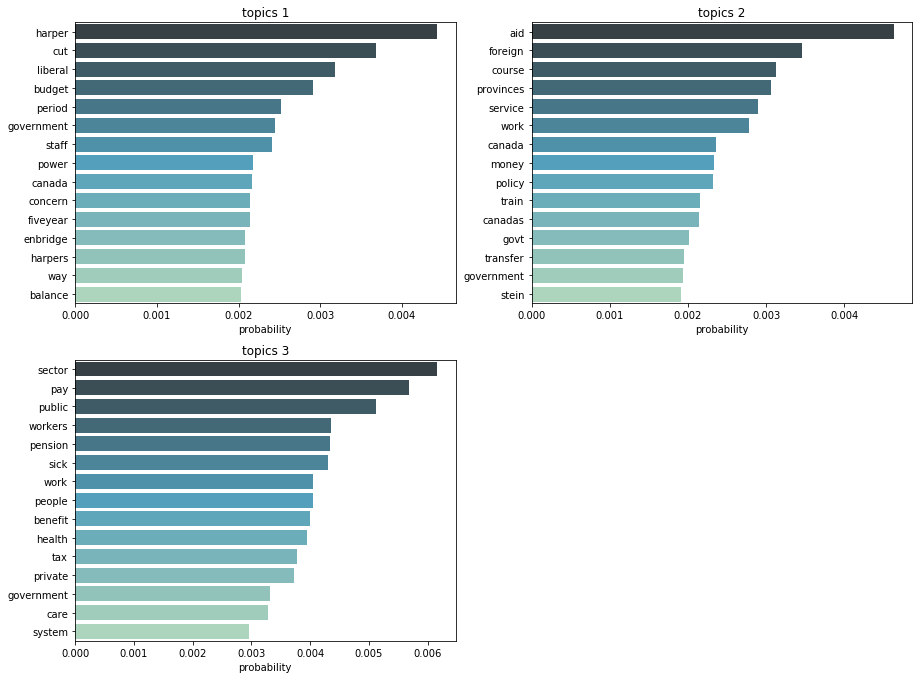

In [240]:
fiz=plt.figure(figsize=(15,30))
for i in range(3):
    plt.subplot(5,2,i+1)
    plt.title('topics '+str(i+1))
    sns.barplot(x=yy['termWeights'][i], y=yy['topics_words'][i], data=yy, label='Cities', palette='GnBu_d')
    plt.xlabel('probability')
plt.show()

In [210]:
yy = yy.to_excel('topics_spark.xlsx')

In [241]:
features_words = transformed.withColumn("comments_words", indices_to_terms(cvmodel.vocabulary)("features"))

In [242]:
features_words.show(3, truncate = False)

+--------------------+--------------------+--------------------+
|            features|   topicDistribution|      comments_words|
+--------------------+--------------------+--------------------+
|(6656,[0,9,28,31,...|[0.00177947888481...|[pay, work, work,...|
|(6656,[1,14,38,74...|[0.83283161577517...|[work, government...|
|(6656,[131,140,33...|[0.00496104846695...|[work, work, work...|
+--------------------+--------------------+--------------------+
only showing top 3 rows



In [243]:
features_words.toPandas()

,features,topicDistribution,comments_words
0,"(1.71579792843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00177845393118, 0.43946802263, 0.558753523439]","[pay, work, work, work, work, work, work, work..."
1,"(0.0, 3.63000915702, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.832824817338, 0.00303283850055, 0.164142344...","[work, government, work, work, work, work, wor..."
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00496234921287, 0.989955290641, 0.005082360...","[work, work, work, work, work, work, work, wor..."
3,"(1.71579792843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.770094585431, 0.00188707946977, 0.228018335...","[pay, work, work, work, work, work, work, work..."
4,"(0.0, 3.63000915702, 0.0, 1.7496994801, 0.0, 0...","[0.204717468006, 0.427699534003, 0.367582997991]","[work, government, work, pay, work, work, work..."
5,"(3.43159585685, 1.81500457851, 0.0, 0.0, 0.0, ...","[0.354969502903, 0.00176866261174, 0.643261834...","[government, pay, work, work, work, work, work..."
6,"(0.0, 0.0, 0.0, 1.7496994801, 0.0, 1.904808473...","[0.00138360557051, 0.0943995122316, 0.90421688...","[work, work, work, pay, work, pay, work, work,..."
7,"(1.71579792843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.917249901203, 0.00306825926426, 0.079681839...","[pay, work, work, work, work, work, work, work..."
8,"(1.71579792843, 3.63000915702, 0.0, 0.0, 0.0, ...","[0.640438010351, 0.0020294474717, 0.357532542178]","[pay, government, work, work, work, pay, work,..."
9,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0507085373731, 0.895944810739, 0.0533466518...","[work, work, work, work, work, work, work, wor..."
